In [18]:
import sys
import yaml
import phate
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import scipy
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms 

import torch.nn as nn
import torch
import math
from tqdm import tqdm


sys.path.append("../")
from src.models.lit_encoder import LitAutoencoder
from src.data.make_dataset import train_dataloader
from src.models.lit_node import NODE, ToyODE
from src.constants import USER_DIR

In [6]:
sys.path.append("../../")
from MNISTDiffusion.unet import Unet

In [7]:
class MNISTDiffusion(nn.Module):
    def __init__(self,image_size,in_channels,time_embedding_dim=256,timesteps=1000,base_dim=32,dim_mults= [1, 2, 4, 8]):
        super().__init__()
        self.timesteps=timesteps
        self.in_channels=in_channels
        self.image_size=image_size

        betas=self._cosine_variance_schedule(timesteps)

        alphas=1.-betas
        alphas_cumprod=torch.cumprod(alphas,dim=-1)

        self.register_buffer("betas",betas)
        self.register_buffer("alphas",alphas)
        self.register_buffer("alphas_cumprod",alphas_cumprod)
        self.register_buffer("sqrt_alphas_cumprod",torch.sqrt(alphas_cumprod))
        self.register_buffer("sqrt_one_minus_alphas_cumprod",torch.sqrt(1.-alphas_cumprod))

        self.model=Unet(timesteps,time_embedding_dim,in_channels,in_channels,base_dim,dim_mults)

    def forward(self,x,noise):
        # x:NCHW
        t=torch.randint(0,self.timesteps,(x.shape[0],)).to(x.device)
        x_t=self._forward_diffusion(x,t,noise)
        pred_noise=self.model(x_t,t)

        return pred_noise

    @torch.no_grad()
    def sampling(self,n_samples,clipped_reverse_diffusion=True,device="cuda"):
        x_t=torch.randn((n_samples,self.in_channels,self.image_size,self.image_size)).to(device)
        for i in tqdm(range(self.timesteps-1,-1,-1),desc="Sampling"):
            noise=torch.randn_like(x_t).to(device)
            t=torch.tensor([i for _ in range(n_samples)]).to(device)

            if clipped_reverse_diffusion:
                x_t=self._reverse_diffusion_with_clip(x_t,t,noise)
            else:
                x_t=self._reverse_diffusion(x_t,t,noise)

        x_t=(x_t+1.)/2. #[-1,1] to [0,1]

        return x_t
    
    def _cosine_variance_schedule(self,timesteps,epsilon= 0.008):
        steps=torch.linspace(0,timesteps,steps=timesteps+1,dtype=torch.float32)
        f_t=torch.cos(((steps/timesteps+epsilon)/(1.0+epsilon))*math.pi*0.5)**2
        betas=torch.clip(1.0-f_t[1:]/f_t[:timesteps],0.0,0.999)

        return betas

    def _forward_diffusion(self,x_0,t,noise):
        assert x_0.shape==noise.shape
        #q(x_{t}|x_{t-1})
        return self.sqrt_alphas_cumprod.gather(-1,t).reshape(x_0.shape[0],1,1,1)*x_0+ \
                self.sqrt_one_minus_alphas_cumprod.gather(-1,t).reshape(x_0.shape[0],1,1,1)*noise


    @torch.no_grad()
    def _reverse_diffusion(self,x_t,t,noise):
        '''
        p(x_{t-1}|x_{t})-> mean,std
        pred_noise-> pred_mean and pred_std
        '''
        pred=self.model(x_t,t)

        alpha_t=self.alphas.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        alpha_t_cumprod=self.alphas_cumprod.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        beta_t=self.betas.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        sqrt_one_minus_alpha_cumprod_t=self.sqrt_one_minus_alphas_cumprod.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        mean=(1./torch.sqrt(alpha_t))*(x_t-((1.0-alpha_t)/sqrt_one_minus_alpha_cumprod_t)*pred)

        if t.min()>0:
            alpha_t_cumprod_prev=self.alphas_cumprod.gather(-1,t-1).reshape(x_t.shape[0],1,1,1)
            std=torch.sqrt(beta_t*(1.-alpha_t_cumprod_prev)/(1.-alpha_t_cumprod))
        else:
            std=0.0

        return mean+std*noise 


    @torch.no_grad()
    def _reverse_diffusion_with_clip(self,x_t,t,noise): 
        '''
        p(x_{0}|x_{t}),q(x_{t-1}|x_{0},x_{t})->mean,std
        pred_noise -> pred_x_0 (clip to [-1.0,1.0]) -> pred_mean and pred_std
        '''
        pred=self.model(x_t,t)
        alpha_t=self.alphas.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        alpha_t_cumprod=self.alphas_cumprod.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        beta_t=self.betas.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        
        x_0_pred=torch.sqrt(1. / alpha_t_cumprod)*x_t-torch.sqrt(1. / alpha_t_cumprod - 1.)*pred
        x_0_pred.clamp_(-1., 1.)

        if t.min()>0:
            alpha_t_cumprod_prev=self.alphas_cumprod.gather(-1,t-1).reshape(x_t.shape[0],1,1,1)
            mean= (beta_t * torch.sqrt(alpha_t_cumprod_prev) / (1. - alpha_t_cumprod))*x_0_pred +\
                 ((1. - alpha_t_cumprod_prev) * torch.sqrt(alpha_t) / (1. - alpha_t_cumprod))*x_t

            std=torch.sqrt(beta_t*(1.-alpha_t_cumprod_prev)/(1.-alpha_t_cumprod))
        else:
            mean=(beta_t / (1. - alpha_t_cumprod))*x_0_pred #alpha_t_cumprod_prev=1 since 0!=1
            std=0.0

        return mean+std*noise 

In [43]:
device="cpu"
model=MNISTDiffusion(timesteps=1000,
                image_size=28,
                in_channels=1,
                base_dim=64,
                dim_mults=[2,4]).to(device)

In [44]:
ckpt=torch.load(USER_DIR+"/MNISTDiffusion/results/steps_00002345.pt")
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [45]:
model

MNISTDiffusion(
  (model): Unet(
    (init_conv): ConvBnSiLu(
      (module): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
    )
    (time_embedding): Embedding(1000, 256)
    (encoder_blocks): ModuleList(
      (0): EncoderBlock(
        (conv0): Sequential(
          (0): ResidualBottleneck(
            (branch1): Sequential(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ConvBnSiLu(
                (module): Sequential(
                  (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
                  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (2): SiLU(inplace=True)
          

In [20]:
def create_mnist_dataloaders(batch_size,image_size=28,num_workers=4):
    
    preprocess=transforms.Compose([transforms.Resize(image_size),\
                                    transforms.ToTensor(),\
                                    transforms.Normalize([0.5],[0.5])]) #[0,1] to [-1,1]

    train_dataset=MNIST(root=USER_DIR+"/MNISTDiffusion/mnist_data",\
                        train=True,\
                        download=True,\
                        transform=preprocess
                        )
    test_dataset=MNIST(root=USER_DIR+"/MNISTDiffusion/mnist_data",\
                        train=False,\
                        download=True,\
                        transform=preprocess
                        )

    return DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers),\
            DataLoader(test_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)

In [21]:
train_dataloader,test_dataloader=create_mnist_dataloaders(batch_size=128,image_size=28)

/home/mila/g/guillaume.huguet/.conda/envs/phate_fim/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [26]:
# Get one training batche
images, labels = next(iter(train_dataloader))
images.shape, labels.shape

/home/mila/g/guillaume.huguet/.conda/envs/phate_fim/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [28]:
pred = model.model(images)

In [29]:
pred.shape

torch.Size([128, 1, 28, 28])

Trying the interpolation with sample net

In [134]:
# Model
# unet=MNISTDiffusion(timesteps=1000,
#                 image_size=28,
#                 in_channels=1,
#                 base_dim=64,
#                 dim_mults=[2,4]).to(device).model
fn_ode = ToyODE(28*28, [200, 200])
neural_ode = NODE(fn_ode, method="rk4")

In [143]:
x0 = images[0]
x1 = images[10]
n_steps = 10
optimizer = torch.optim.AdamW(params=neural_ode.parameters(), lr=0.001)
n_epochs = 500

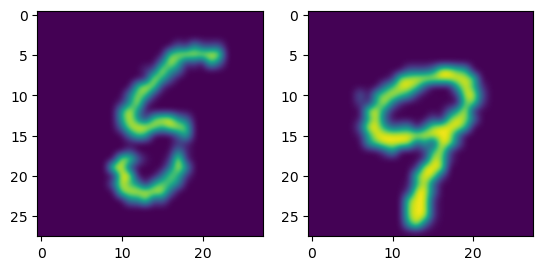

In [144]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(transforms.ToPILImage()(x0), interpolation="bicubic")
axes[1].imshow(transforms.ToPILImage()(x1), interpolation="bicubic")

In [145]:
x0_f = x0.flatten().unsqueeze(0)
x1_f = x1.flatten().unsqueeze(0)
neural_ode(x0_f, n_steps).shape

torch.Size([10, 1, 784])

In [154]:
neural_ode.train()

for epoch in range(n_epochs):

    optimizer.zero_grad()

    path = neural_ode(x0_f, n_steps).squeeze(1)

    x1_pred = path[-1].view(1,-1)

    pred_loss = torch.nn.MSELoss()(x1_pred, x1_f)
    cost = []
    for idx, p in enumerate(path):
        t = torch.tensor([idx+1])
        jac = model.model(p.view(1,1,28,28)).view(1,-1)
        vel = neural_ode.fn_ode(t,p.view(1,-1))
        c = torch.sqrt(vel @ jac.T @ jac @ vel.T) # TODO: does not look correct..
        cost.append(c)
    loss = sum(cost) / len(cost) + 10*pred_loss

    if epoch % 100 == 0:
        print(loss)

    loss.backward()
    optimizer.step()

tensor([[5.8467]], grad_fn=<AddBackward0>)
tensor([[0.7550]], grad_fn=<AddBackward0>)
tensor([[0.3268]], grad_fn=<AddBackward0>)
tensor([[0.3762]], grad_fn=<AddBackward0>)
tensor([[0.2074]], grad_fn=<AddBackward0>)


In [155]:
path = neural_ode(x0_f, n_steps).squeeze(1)
path = torch.cat((path,x1_f)).detach()

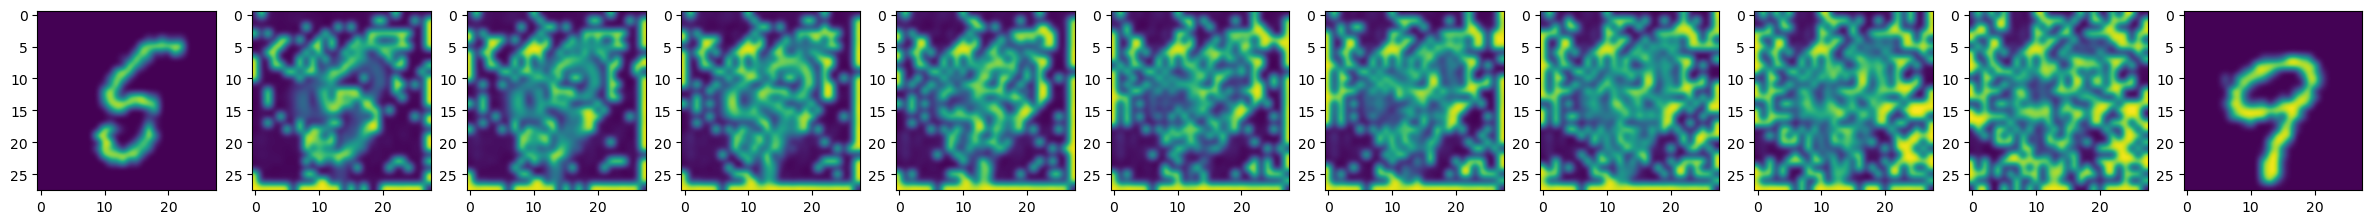

In [156]:
fig, axes = plt.subplots(1,n_steps+1, figsize=(30,60))
for idx, ax in enumerate(axes):
    ax.imshow(transforms.ToPILImage()(path[idx].view(28,28)), interpolation="bicubic")


In [151]:
# ONLY WITH THE MSE LOSS   
fn_ode = ToyODE(28*28, [200, 200])
neural_ode = NODE(fn_ode, method="rk4")

x0 = images[0]
x1 = images[10]
n_steps = 10
optimizer = torch.optim.AdamW(params=neural_ode.parameters(), lr=0.001)
n_epochs = 500

neural_ode.train()

for epoch in range(n_epochs):

    optimizer.zero_grad()

    path = neural_ode(x0_f, n_steps).squeeze(1)

    x1_pred = path[-1].view(1,-1)

    pred_loss = torch.nn.MSELoss()(x1_pred, x1_f)

    loss = pred_loss

    if epoch % 100 == 0:
        print(loss)

    loss.backward()
    optimizer.step()

tensor(1.6201, grad_fn=<MseLossBackward0>)
tensor(7.7215e-06, grad_fn=<MseLossBackward0>)
tensor(2.9479e-10, grad_fn=<MseLossBackward0>)
tensor(4.0411e-11, grad_fn=<MseLossBackward0>)
tensor(2.8898e-11, grad_fn=<MseLossBackward0>)


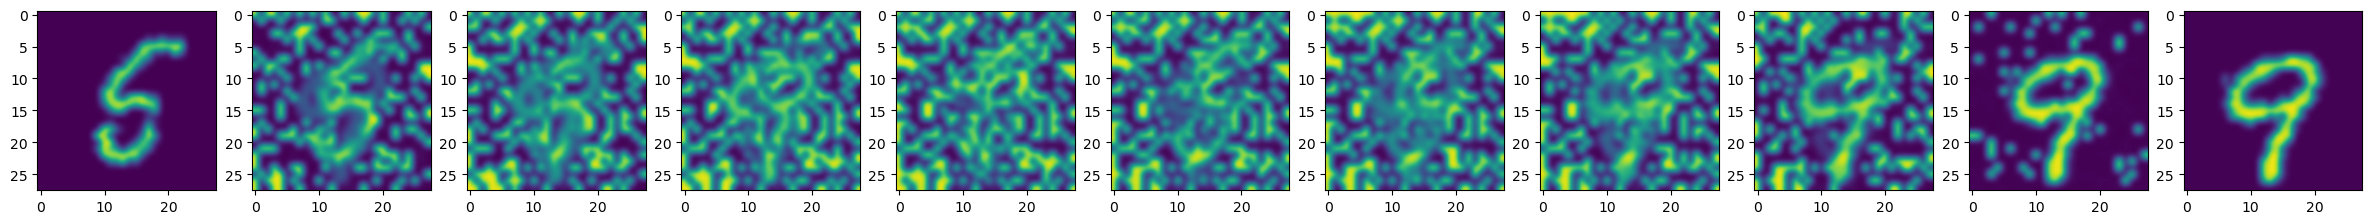

In [153]:
path = neural_ode(x0_f, n_steps).squeeze(1)
path = torch.cat((path,x1_f)).detach()

fig, axes = plt.subplots(1,n_steps+1, figsize=(30,60))
for idx, ax in enumerate(axes):
    ax.imshow(transforms.ToPILImage()(path[idx].view(28,28)), interpolation="bicubic")